In [2]:
!pip install transformers
!pip install --upgrade accelerate
!pip install evaluate
!pip install nltk
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 7.1 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 224 kB 57.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 19.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 219 kB 3.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 81 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 213 kB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 52.1 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 58.1 MB/s eta 0:00:01
     |████████████████████████████████| 474 k

In [36]:
import os
import numpy as np

data_path= '../datasets/iam/'

if not os.path.exists(os.path.join(data_path, 'imgs')):
    
    os.mkdir(os.path.join(data_path, 'imgs'))
    os.system(f'tar -xf {data_path}/formsA-D.tgz --directory {data_path}/imgs/')
    os.system(f'tar -xf {data_path}/formsE-H.tgz --directory {data_path}/imgs/')
    os.system(f'tar -xf {data_path}/formsI-Z.tgz --directory {data_path}/imgs/')
    
    import random
    import shutil
    
    data_path = os.path.join(data_path, 'imgs')
    
    all_files = os.listdir(data_path)
    
    all_png_files = [x for x in all_files if x.endswith('.png')]
    
    print(set(all_files) - set(all_png_files))
    
    random.shuffle(all_png_files)

    split = random.choices(['train', 'valid', 'test'], [0.85, 0.075, 0.075], k = len(all_png_files))
    
    os.mkdir(os.path.join(data_path, 'train'))
    os.mkdir(os.path.join(data_path, 'valid'))
    os.mkdir(os.path.join(data_path, 'test'))
    
    total_path = lambda file_name: os.path.join(data_path, file_name)

    for file_name, mode in zip(all_png_files, split):

        src_path = total_path(file_name)
        dst_path = os.path.join(data_path, mode, file_name)

        shutil.move(src_path, dst_path)

    for s in ['train', 'valid', 'test']:
        print(s, int(len(os.listdir(os.path.join(data_path, f'{s}')))))
        
else:
    for s in ['train', 'valid', 'test']:
        print(s, int(len(os.listdir(os.path.join(data_path, f'imgs/{s}')))))

train 1308
valid 109
test 122


## TROCR

In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image
import torch

In [114]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained('tokenizer/')

special_tokens = {tokenizer.bos_token_id, tokenizer.pad_token_id, tokenizer.eos_token_id, tokenizer.unk_token_id, tokenizer.mask_token_id}
special_tokens

{0, 1, 2, 3, 50264}

In [169]:
sentence = 'the cat is on the mat'
caption_ids = tokenizer(sentence, padding='max_length', max_length = 11).input_ids
caption_ids

[0, 627, 4758, 16, 15, 5, 7821, 2, 1, 1, 1]

In [173]:
[tokenizer.decode(x) for x in caption_ids]

['<s>',
 'the',
 ' cat',
 ' is',
 ' on',
 ' the',
 ' mat',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>']

In [171]:
caption_ids[:9]

[0, 627, 4758, 16, 15, 5, 7821, 2, 1]

In [172]:
tokenizer.decode([x for x in caption_ids if x not in special_tokens])

'the cat is on the mat'

In [117]:
len(tokenizer)

50265

In [118]:
tokenizer

RobertaTokenizerFast(name_or_path='tokenizer/', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)

## Data Processing

In [188]:
import torch
import pandas as pd
import re, os
import numpy as np

np.random.seed(42)

class HandWrittenDataset(torch.utils.data.Dataset):
    def __init__(self, processor, number_of_lines = 1, split = 'train', path = '../datasets/iam/'):
        assert number_of_lines > 0
        assert split in {'train', 'valid', 'test'}
        
        self.path = path
        self.split = split
        self.processor = processor
        
        with open(os.path.join(self.path, 'lines.txt'), 'r') as f:
            lines = f.readlines()

        self.description = lines[:23]
        data = lines[23:]

        rows = []
        for line in data:
            temp = line.split()
            row = temp[:8]
            row.extend([' '.join(temp[8:])])
            rows.append(row)

        cols = ['id', 'result', 'graylevel', 'components', 'x', 'y', 'w', 'h', 'message']

        df = pd.DataFrame(rows, columns=cols)
        for col in ['components', 'graylevel', 'x', 'y', 'w', 'h']:
            df[col] = df[col].astype('int64')

        def clean_message(m):
            m = m.replace('|-|', ' - ')
            m = m.replace('|*|', ' * ')
            temp0 = m.replace('.|"', '"|.')
            temp1 = re.sub(r'"\|([\w\d\s\|-]+)\|"', r'"\1"', temp0)
            temp2 = re.sub(r'([^\'\(])\|([\w\d\"\#\(])', r'\1 \2', temp1)
            temp3 = re.sub(r'([^\'\(\"])\|([\w\d\"\#\(])', r'\1 \2', temp2)
            temp4 = re.sub(r'^"\s', r'"', temp3)
            return temp4.replace('|', '').replace(' ". ', '". ')

        df['clean_message'] = df['message'].apply(clean_message)
        
        self.df = df
        self.max_target_length = 30*number_of_lines
        self.length = number_of_lines
        
        file_list = os.listdir(os.path.join(self.path, 'imgs', split))
        
        self.img_names = [x.replace('.png', '') for x in file_list if x.endswith('.png')]
        
    def __getitem__(self, idx):
        
        img_name = self.img_names[idx]
        sample_df = self.df[self.df['id'].str.contains(img_name + '-')]
        image = Image.open(os.path.join(self.path, 'imgs', self.split, f'{img_name}.png')).convert("RGB")
        delta = 20
        
        start = np.random.choice(range(max(len(sample_df) - self.length + 1, 1)))

        array = np.asarray(image)
        xmin = min(sample_df['x'])
        xmax = max(sample_df['x']) + max(sample_df['w'])

        ymin = sample_df['y'].iloc[start]

        end = min(start + min(self.length, len(sample_df)), len(sample_df)) - 1

        ymax = sample_df['y'].iloc[end] + sample_df['h'].iloc[end]
        
        l, w, _ = array.shape
        a = max(ymin-delta,0)
        b = min(ymax+delta,l-1)
        c = max(xmin-delta,0)
        d = min(xmax+delta,w-1)
        
        img = Image.fromarray(array[a:b, c:d, :])
        
        #new_size = (384, 192)
        
        #img = img.resize(size = new_size)
        
        return {'image': img, 'text': ' '.join(sample_df['clean_message'].iloc[start:end+1])}
    
    def __len__(self):
        return len(self.img_names)
    

import numpy as np

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator



def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = processor.tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
    decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != processor.tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [189]:
save_path = "../hand-written-text-recognition/handwritten-recognition-output"
processor = TrOCRProcessor.from_pretrained(save_path)
dataset= HandWrittenDataset(processor)

had a whispered conversation.
(1992, 155)


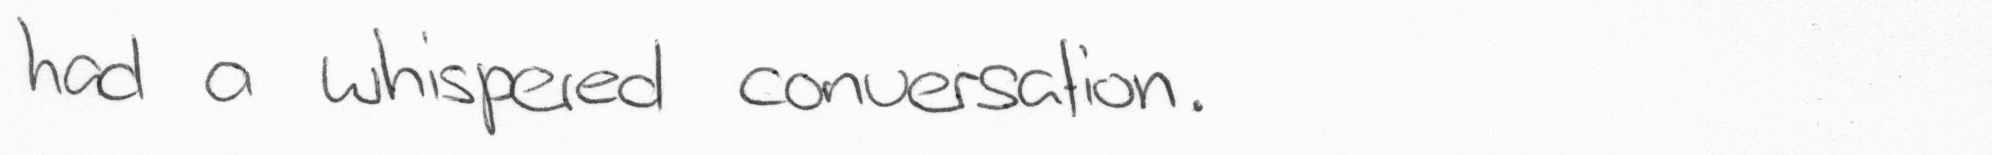

In [251]:
import random
idx = random.randint(0, 109)
datapoint = dataset[idx]
print(datapoint['text'])
image = datapoint['image']
print(image.size)
image

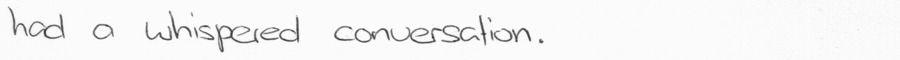

In [296]:
image.resize((900, 60))

In [252]:
image.save(f'test-imgs/train-{idx}.png')

In [259]:
[x for x in os.listdir('test-imgs/') if x.endswith('.png')]

['train-103.png',
 'train-102.png',
 'train-31.png',
 'train-99.png',
 'valid-108.png',
 'valid-4.png',
 'valid-1.png',
 'valid-51.png',
 'train-81.png',
 'train-38.png',
 'valid-10.png',
 'train-56.png']

In [68]:
encoded_image_size = (28, 14)

In [69]:
import torchvision
from torch import nn

resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101
modules = list(resnet.children())[:-2]

resnet = nn.Sequential(*modules)

adaptive_pool = nn.AdaptiveAvgPool2d(encoded_image_size)

In [70]:
out = resnet(torch.FloatTensor(img).unsqueeze(0))
out.shape

torch.Size([1, 2048, 4, 20])

In [64]:
final = adaptive_pool(out).permute(0, 2, 3, 1)
final.shape

torch.Size([1, 28, 14, 2048])

In [119]:
original_size = np.array(datapoint['image'].size)
original_size

NameError: name 'datapoint' is not defined

In [ ]:
new_size = (384, 192)

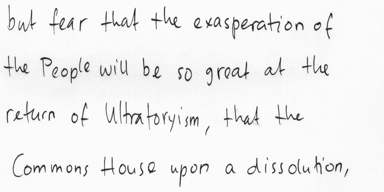

In [76]:
datapoint['image'].resize(new_size)

In [5]:
save_path = "./handwritten-recognition-output"
number_of_lines = 4
height = number_of_lines*384//2

import json
with open(os.path.join(save_path, "config.json"), 'r') as f:
    config = json.load(f)
    
config['encoder']['image_size'] = [height, 384]
with open(os.path.join(save_path, "config.json"), 'w') as f:
    json.dump(config, f)


processor = TrOCRProcessor.from_pretrained(save_path)
model = VisionEncoderDecoderModel.from_pretrained(save_path, ignore_mismatched_sizes=True)

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

processor.image_processor.size['height'] = height         ####CHECKK!!!!!!
model.config.decoder.max_length = 20*number_of_lines      ####CHECKK!!!!!!


processed_dataset = {'train': HandWrittenDataset(processor, number_of_lines, split = 'train'), 
                     'validation': HandWrittenDataset(processor, number_of_lines, split = 'validation')}

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    num_train_epochs=50,
    evaluation_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    output_dir=save_path
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    data_collator=default_data_collator,
)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at ./handwritten-recognition-output and are newly initialized because the shapes did not match:
- encoder.embeddings.position_embeddings: found shape torch.Size([1, 577, 768]) in the checkpoint and torch.Size([1, 1153, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[1684416896.400290] [4f23288ec416:321486:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,1.471993,13.207400,1.289700,11.215700,11.894800,19.741379
2,No log,1.449480,10.299800,0.426600,8.578900,9.177900,20.000000
3,No log,1.350869,10.751400,0.328100,8.833300,9.572700,20.000000
4,No log,1.297714,16.383000,0.806900,12.472300,14.672000,20.000000
5,No log,1.267350,16.250200,1.911600,13.402500,14.844400,20.000000
6,No log,1.130779,14.663800,0.688700,11.599200,13.090900,20.000000
7,No log,1.141384,16.309900,1.030200,13.073800,14.136600,20.000000
8,No log,1.070333,14.225100,0.221800,11.769400,12.491200,20.000000
9,1.323600,1.053568,13.242500,0.856100,10.212400,11.957300,20.000000
10,1.323600,0.973358,19.953400,0.663200,15.402200,17.043700,20.000000


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/para

TrainOutput(global_step=3100, training_loss=0.49530616914072345, metrics={'train_runtime': 7543.7631, 'train_samples_per_second': 2.446, 'train_steps_per_second': 0.411, 'total_flos': 2.7655049191410893e+19, 'train_loss': 0.49530616914072345, 'epoch': 50.0})

In [7]:
trainer.save_model(save_path)
processor.tokenizer.save_pretrained(save_path)
processor.save_pretrained(save_path)

In [9]:
processor = TrOCRProcessor.from_pretrained(save_path)
model = VisionEncoderDecoderModel.from_pretrained(save_path)

In [14]:
number_of_lines

4

In [16]:
dataset = HandWrittenDataset(processor, number_of_lines, split = 'validation')

# load image from the IAM dataset
datapoint = dataset.getchunk(23)

image = datapoint['image']
text = datapoint['text']

#image = Image.open('test-imgs/test2.png').convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values

# inference (generation)
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (80) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [17]:
generated_text

"The film version of Miss Shelagh Delaney's play A Taste of Honey opens at the Leicester Square Theatre tomorrow. It has been produced and directed by Mr. Tony Richardson, who is also part-"

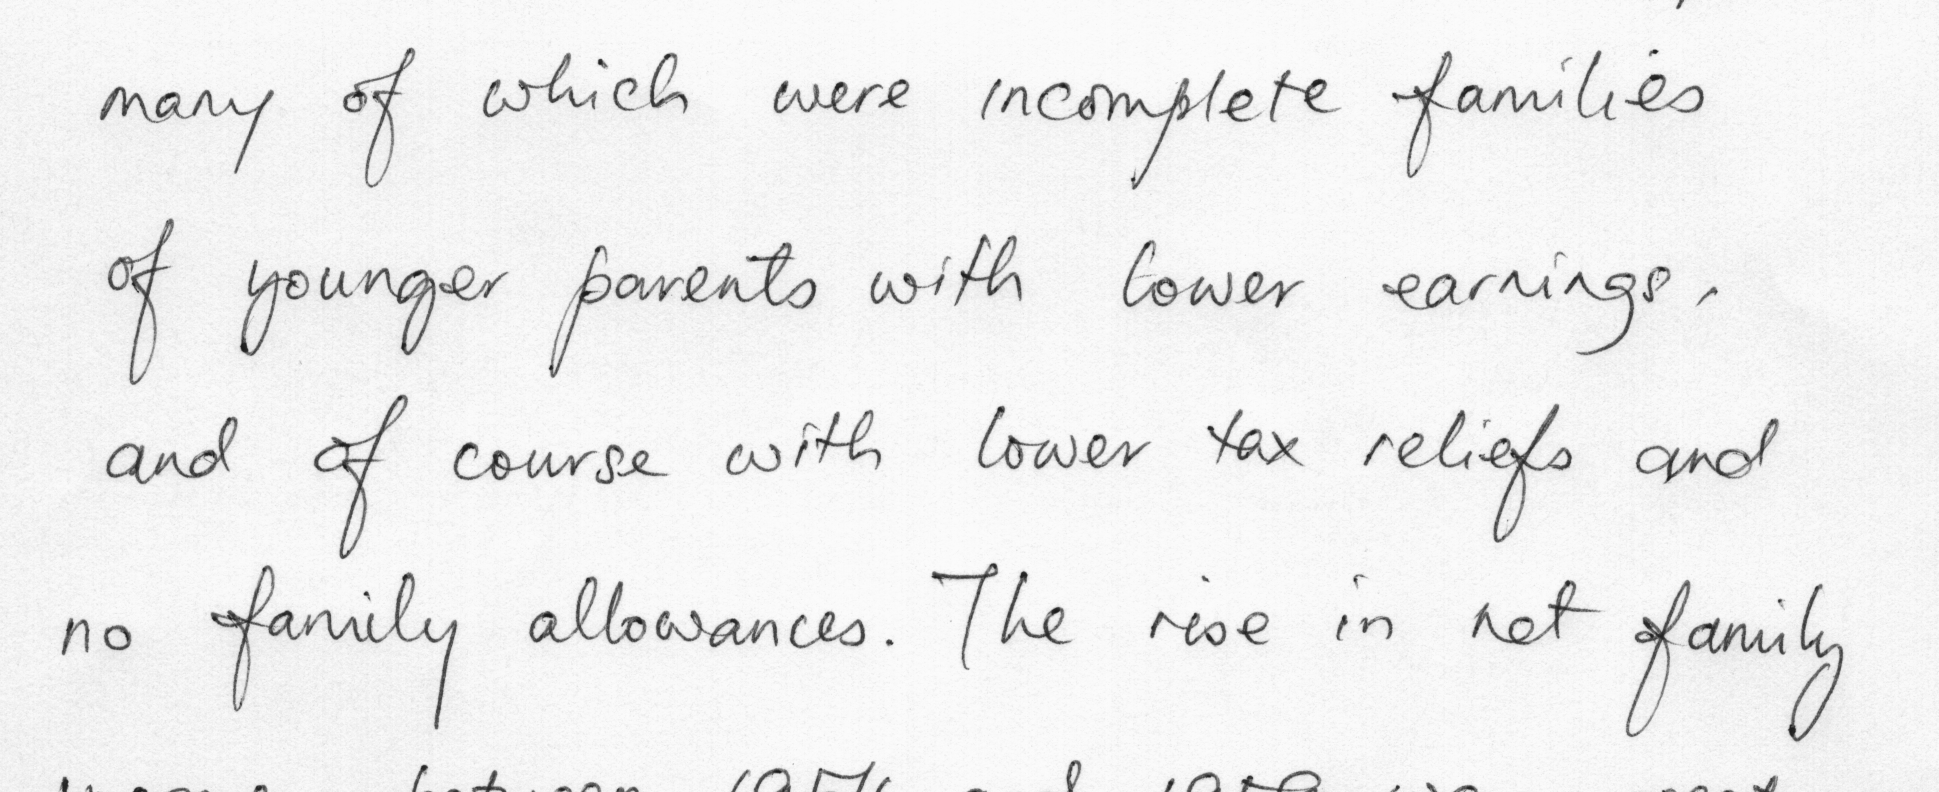

In [19]:
image

In [1]:
image

NameError: name 'image' is not defined